# Load Model & Dataset

## Import Module

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.5MB 4.9MB/s 
     |████████████████████████████████| 3.3MB 30.7MB/s 
     |████████████████████████████████| 901kB 58.9MB/s 


In [ ]:
import re
import time
import pandas as pd
import numpy as np
import pickle
import tensorflow as tf
import torch
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.utils import shuffle
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from transformers import ElectraTokenizer, TFElectraForSequenceClassification
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from transformers import AutoTokenizer, AutoModel, DistilBertModel
import warnings
warnings.filterwarnings(action='ignore')

## Dataset

In [ ]:
# Train dataset / Validation dataset
df_t = pd.read_csv("/content/drive/MyDrive/HateSpeech/FINAL_DATASET/Final_dataset_balanced.csv")
df_t = df_t.dropna()
df_t = df_t[(df_t['text'].apply(len)<1000)]
X = df_t['text']
y = df_t['class']

NameError: ignored

## BERTs

In [ ]:
# ELECTRA
tokenizer_electra = ElectraTokenizer.from_pretrained('google/electra-small-discriminator')
model_electra = AutoModel.from_pretrained('google/electra-small-discriminator')

# DISTIL
tokenizer_distilbert = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model_distilbert = AutoModel.from_pretrained('distilbert-base-uncased')

# SQUEEZE
tokenizer_squeezebert = AutoTokenizer.from_pretrained("squeezebert/squeezebert-uncased")
model_squeezebert = AutoModel.from_pretrained("squeezebert/squeezebert-uncased")

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraModel: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of the model checkpoint at squeezebert/squeezebert-uncased were not used when initializing SqueezeBertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing SqueezeBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SqueezeBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## GloVe

In [ ]:
# Train dataset / Validation dataset
df = pd.read_csv("/content/drive/MyDrive/HateSpeech/FINAL_DATASET/Final_dataset_balanced.csv")
df = df.dropna()
df_train, df_val = train_test_split(df,test_size=0.2,random_state = 42)
# Test dataset
df_test = pd.read_csv("/content/drive/MyDrive/HateSpeech/hateXplain.csv")
print(df_train.shape,df_val.shape,df_test.shape)
df_train = df_train[(df_train['text'].apply(len)<1000)]
df_val = df_val[(df_val['text'].apply(len)<1000)]
df_test = df_test[(df_test['text'].apply(len)<1000)]
print(df_train.shape,df_val.shape,df_test.shape)
X_train = df_train['text']
y_train = df_train['class']
X_val = df_val['text']
y_val = df_val['class']
X_test = df_test['text']
y_test = df_test['class']

(123424, 3) (30856, 3) (15351, 3)
(119868, 3) (29931, 3) (15351, 3)


In [ ]:
import numpy as np
embeddings_index = {}
f = open("/content/drive/MyDrive/HateSpeech/glove.6B.100d.txt")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:

# Initialization
max_features=100000
sequence_length = 235
embedding_dim = 100
num_words = 100001

# Tokenizing
data_start = time.time()
tokenizer = Tokenizer(num_words=max_features, split=' ', oov_token='<unw>', filters=' ')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, sequence_length)

word_index = tokenizer.word_index
embedding_matrix_train = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i > max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix_train[i] = embedding_vector
    else:
        embedding_matrix_train[i] = np.random.randn(embedding_dim)

## BiLSTM

In [ ]:
from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import *

def build_model(num_words,embedding_matrix):
  model = Sequential()
  model.add(Embedding(num_words,
                      embedding_dim,
                      embeddings_initializer=Constant(embedding_matrix),
                      input_length=sequence_length,
                      trainable=True))
  model.add(SpatialDropout1D(0.2))
  model.add(Bidirectional(LSTM(64, return_sequences=True)))
  model.add(Bidirectional(LSTM(32)))
  model.add(Dropout(0.25))
  model.add(Dense(units=1, activation='sigmoid'))
  model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
  return model

In [ ]:
filepath = "/content/drive/MyDrive/HateSpeech/Weight/GloVe_BiLSTM"
BiLSTM = build_model(num_words,embedding_matrix_train)
BiLSTM.load_weights(filepath)

In [ ]:
x = tokenizer.texts_to_sequences(["FEWJO fweop fuck fuck fuck fuck fuck sex hdffdh fh sex fuck fuck dsFPOfpds sdfp ofdspjo"])
x = pad_sequences(x, sequence_length)
BiLSTM.predict_classes(x)

array([[1]], dtype=int32)

# RandomSampling

In [ ]:
df_sample = pd.DataFrame(df_t.sample(10000,random_state=42)).iloc[:,1:].reset_index(drop=True)
df_sample

,text,class
0,it depends how you define world the war which ...,0
1,don't no nigga want an artificial bitch let m...,1
2,how do i overcome what i've read and seen in 1...,0
3,who's transphobic now?,0
4,i am a christian and i know there are very con...,0
...,...,...
9995,wintertime bout to turn the grind back on do...,1
9996,i hate when im singing a song and somebody els...,1
9997,corrected name of the chairman source,0
9998,retard central for sure,1


In [ ]:
X=df_sample['text'].to_list()
y=df_sample['class'].to_list()

# EMBEDDING

## Squeeze

In [ ]:
encoding_time = time.time()
train_encodings = tokenizer_squeezebert(X, truncation=True, padding=True)
print("encoding time : ", time.time()-encoding_time)

dataset_time = time.time()
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y
))
print("dataset time : ", time.time()-dataset_time)

encoding time :  1.0545661449432373


In [ ]:
i=0
start = time.time()
for pred in train_dataset.batch(64):
  if i%1==0 : 
    lef = len(df_sample)/64
    print(i,'/',int(lef),end='\t')
    ela = time.time()-start
    print(round(ela,0),'s',end='\t')
    print(round(ela*(lef-i)/10,0),'s',end='\t')
    if i>0: print("SHAPE :",temp.shape,y_temp.shape)
    start = time.time()
  if i == 0:
    with torch.no_grad():
        temp = model_squeezebert(torch.tensor(np.array(pred[0]['input_ids'])))[0][:,0,:]
    y_temp = pred[1]
    i+=1
  else :
    with torch.no_grad():
        temp_input = model_squeezebert(torch.tensor(np.array(pred[0]['input_ids'])))[0][:,0,:]
    temp = np.append(temp,temp_input,axis=0)
    y_temp = np.append(y_temp,pred[1])
    i+=1

0 / 156	0.0 s	0.0 s	1 / 156	25.0 s	388.0 s	SHAPE : torch.Size([64, 768]) (64,)
2 / 156	25.0 s	386.0 s	SHAPE : (128, 768) (128,)
3 / 156	25.0 s	385.0 s	SHAPE : (192, 768) (192,)
4 / 156	25.0 s	381.0 s	SHAPE : (256, 768) (256,)
5 / 156	25.0 s	378.0 s	SHAPE : (320, 768) (320,)
6 / 156	25.0 s	376.0 s	SHAPE : (384, 768) (384,)
7 / 156	25.0 s	373.0 s	SHAPE : (448, 768) (448,)
8 / 156	25.0 s	371.0 s	SHAPE : (512, 768) (512,)
9 / 156	25.0 s	368.0 s	SHAPE : (576, 768) (576,)
10 / 156	25.0 s	365.0 s	SHAPE : (640, 768) (640,)
11 / 156	25.0 s	362.0 s	SHAPE : (704, 768) (704,)
12 / 156	25.0 s	359.0 s	SHAPE : (768, 768) (768,)
13 / 156	25.0 s	356.0 s	SHAPE : (832, 768) (832,)
14 / 156	25.0 s	354.0 s	SHAPE : (896, 768) (896,)
15 / 156	25.0 s	350.0 s	SHAPE : (960, 768) (960,)
16 / 156	25.0 s	350.0 s	SHAPE : (1024, 768) (1024,)
17 / 156	25.0 s	346.0 s	SHAPE : (1088, 768) (1088,)
18 / 156	25.0 s	343.0 s	SHAPE : (1152, 768) (1152,)
19 / 156	25.0 s	341.0 s	SHAPE : (1216, 768) (1216,)
20 / 156	25.0 s	338.0

In [ ]:
import pickle
with open("/content/drive/MyDrive/HateSpeech/visual/squeeze_emb.pickle","wb") as f :
  pickle.dump([temp,y_temp],f)

## Distil

In [ ]:
encoding_time = time.time()
train_encodings = tokenizer_distilbert(X, truncation=True, padding=True)
print("encoding time : ", time.time()-encoding_time)

dataset_time = time.time()
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y
))
print("dataset time : ", time.time()-dataset_time)

encoding time :  8.186341762542725
dataset time :  16.233379364013672


In [ ]:
i=0
start = time.time()
for pred in train_dataset.batch(64):
  if i%1==0 : 
    lef = len(df_sample)/64
    print(i,'/',int(lef),end='\t')
    ela = time.time()-start
    print(round(ela,0),'s',end='\t')
    print(round(ela*(lef-i),0),'s',end='\t')
    if i>0: print("SHAPE :",temp.shape,y_temp.shape)
    start = time.time()
  if i == 0:
    with torch.no_grad():
        tempo = model_distilbert(torch.tensor(np.array(pred[0]['input_ids'])))[0]
        temp = tempo[:,:,:]
        temp_emb = tempo[:,0,:]
    y_temp = pred[1]
    i+=1
  else :
    with torch.no_grad():
        tempo = model_distilbert(torch.tensor(np.array(pred[0]['input_ids'])))[0]
        temp_input = tempo[:,:,:]
        temp_input_emb = tempo[:,0,:]
    temp = np.append(temp,temp_input,axis=0)
    temp_emb = np.append(temp_emb,temp_input_emb,axis=0)
    y_temp = np.append(y_temp,pred[1])
    i+=1

0 / 156	0.0 s	2.0 s	1 / 156	17.0 s	2701.0 s	SHAPE : torch.Size([64, 318, 768]) (64,)
2 / 156	17.0 s	2642.0 s	SHAPE : (128, 318, 768) (128,)
3 / 156	17.0 s	2634.0 s	SHAPE : (192, 318, 768) (192,)
4 / 156	17.0 s	2619.0 s	SHAPE : (256, 318, 768) (256,)
5 / 156	17.0 s	2609.0 s	SHAPE : (320, 318, 768) (320,)
6 / 156	17.0 s	2557.0 s	SHAPE : (384, 318, 768) (384,)
7 / 156	17.0 s	2569.0 s	SHAPE : (448, 318, 768) (448,)
8 / 156	17.0 s	2549.0 s	SHAPE : (512, 318, 768) (512,)
9 / 156	17.0 s	2557.0 s	SHAPE : (576, 318, 768) (576,)
10 / 156	17.0 s	2512.0 s	SHAPE : (640, 318, 768) (640,)
11 / 156	17.0 s	2509.0 s	SHAPE : (704, 318, 768) (704,)
12 / 156	17.0 s	2481.0 s	SHAPE : (768, 318, 768) (768,)
13 / 156	17.0 s	2474.0 s	SHAPE : (832, 318, 768) (832,)
14 / 156	17.0 s	2457.0 s	SHAPE : (896, 318, 768) (896,)
15 / 156	17.0 s	2440.0 s	SHAPE : (960, 318, 768) (960,)
16 / 156	17.0 s	2423.0 s	SHAPE : (1024, 318, 768) (1024,)
17 / 156	17.0 s	2433.0 s	SHAPE : (1088, 318, 768) (1088,)
18 / 156	17.0 s	2409.0 

In [ ]:
temp[:5000].shape

(5000, 318, 768)

In [ ]:
import pickle
with open("/content/drive/MyDrive/HateSpeech/visual/distil_emb.pickle","wb") as f :
  pickle.dump([temp_emb,y_temp],f)
with open("/content/drive/MyDrive/HateSpeech/visual/distil_all_01.pickle","wb") as f :
  pickle.dump([temp[:2500],y_temp[:2500]],f)
with open("/content/drive/MyDrive/HateSpeech/visual/distil_all_02.pickle","wb") as f :
  pickle.dump([temp[2500:5000],y_temp[2500:5000]],f)
with open("/content/drive/MyDrive/HateSpeech/visual/distil_all_03.pickle","wb") as f :
  pickle.dump([temp[5000:7500],y_temp[5000:7500]],f)
with open("/content/drive/MyDrive/HateSpeech/visual/distil_all_04.pickle","wb") as f :
  pickle.dump([temp[7500:],y_temp[7500:]],f)

## Electra

In [ ]:
encoding_time = time.time()
train_encodings = tokenizer_electra(X, truncation=True, padding=True)
print("encoding time : ", time.time()-encoding_time)

dataset_time = time.time()
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y
))
print("dataset time : ", time.time()-dataset_time)

encoding time :  8.863424062728882
dataset time :  24.160619735717773


In [ ]:
i=0
start = time.time()
for pred in train_dataset.batch(64):
  if i%1==0 : 
    lef = len(df_sample)/64
    print(i,'/',int(lef),end='\t')
    ela = time.time()-start
    print(round(ela,0),'s',end='\t')
    print(round(ela*(lef-i),0),'s',end='\t')
    if i>0: print("SHAPE :",temp.shape,y_temp.shape)
    start = time.time()
  if i == 0:
    with torch.no_grad():
        tempo = model_electra(torch.tensor(np.array(pred[0]['input_ids'])))[0]
        temp = tempo[:,:,:]
        temp_emb = tempo[:,0,:]
    y_temp = pred[1]
    i+=1
  else :
    with torch.no_grad():
        tempo = model_electra(torch.tensor(np.array(pred[0]['input_ids'])))[0]
        temp_input = tempo[:,:,:]
        temp_input_emb = tempo[:,0,:]
    temp = np.append(temp,temp_input,axis=0)
    temp_emb = np.append(temp_emb,temp_input_emb,axis=0)
    y_temp = np.append(y_temp,pred[1])
    i+=1

0 / 156	0.0 s	38.0 s	1 / 156	7.0 s	1051.0 s	SHAPE : torch.Size([64, 318, 256]) (64,)
2 / 156	6.0 s	930.0 s	SHAPE : (128, 318, 256) (128,)
3 / 156	6.0 s	928.0 s	SHAPE : (192, 318, 256) (192,)
4 / 156	6.0 s	908.0 s	SHAPE : (256, 318, 256) (256,)
5 / 156	6.0 s	933.0 s	SHAPE : (320, 318, 256) (320,)
6 / 156	6.0 s	897.0 s	SHAPE : (384, 318, 256) (384,)
7 / 156	6.0 s	916.0 s	SHAPE : (448, 318, 256) (448,)
8 / 156	6.0 s	889.0 s	SHAPE : (512, 318, 256) (512,)
9 / 156	6.0 s	914.0 s	SHAPE : (576, 318, 256) (576,)
10 / 156	6.0 s	886.0 s	SHAPE : (640, 318, 256) (640,)
11 / 156	6.0 s	880.0 s	SHAPE : (704, 318, 256) (704,)
12 / 156	6.0 s	874.0 s	SHAPE : (768, 318, 256) (768,)
13 / 156	6.0 s	881.0 s	SHAPE : (832, 318, 256) (832,)
14 / 156	6.0 s	865.0 s	SHAPE : (896, 318, 256) (896,)
15 / 156	6.0 s	864.0 s	SHAPE : (960, 318, 256) (960,)
16 / 156	6.0 s	864.0 s	SHAPE : (1024, 318, 256) (1024,)
17 / 156	6.0 s	879.0 s	SHAPE : (1088, 318, 256) (1088,)
18 / 156	6.0 s	842.0 s	SHAPE : (1152, 318, 256) (1152,)

In [ ]:
import pickle
with open("/content/drive/MyDrive/HateSpeech/visual/electra_emb.pickle","wb") as f :
  pickle.dump([temp_emb,y_temp],f)
with open("/content/drive/MyDrive/HateSpeech/visual/electra_all_01.pickle","wb") as f :
  pickle.dump([temp[:2500],y_temp[:2500]],f)
with open("/content/drive/MyDrive/HateSpeech/visual/electra_all_02.pickle","wb") as f :
  pickle.dump([temp[2500:5000],y_temp[2500:5000]],f)
with open("/content/drive/MyDrive/HateSpeech/visual/electra_all_03.pickle","wb") as f :
  pickle.dump([temp[5000:7500],y_temp[5000:7500]],f)
with open("/content/drive/MyDrive/HateSpeech/visual/electra_all_04.pickle","wb") as f :
  pickle.dump([temp[7500:],y_temp[7500:]],f)

## BiLSTM

In [ ]:
model = tf.keras.Sequential(BiLSTM.layers[:-2])

In [ ]:
x = tokenizer.texts_to_sequences(X)
x = pad_sequences(x, sequence_length)
bilstm_emb = model.predict(x)

In [ ]:
bilstm_emb.shape

(10000, 64)

In [ ]:
len(y)

10000

In [ ]:
import pickle
with open("/content/drive/MyDrive/HateSpeech/visual/bilstm.pickle","wb") as f :
  pickle.dump([bilstm_emb,y],f)

# Visualization


## Load pickles

In [ ]:
import pandas as pd
import numpy as np
import glob
import pickle

In [ ]:
pickle_list = glob.glob("/content/drive/MyDrive/HateSpeech/visual/*.pickle")
print(pickle_list)
pickle_list.pop(1)
print(pickle_list)

['/content/drive/MyDrive/HateSpeech/visual/squeeze_emb.pickle', '/content/drive/MyDrive/HateSpeech/visual/distil_all.pickle', '/content/drive/MyDrive/HateSpeech/visual/distil_emb.pickle', '/content/drive/MyDrive/HateSpeech/visual/distil_all_01.pickle', '/content/drive/MyDrive/HateSpeech/visual/distil_all_02.pickle', '/content/drive/MyDrive/HateSpeech/visual/distil_all_03.pickle', '/content/drive/MyDrive/HateSpeech/visual/distil_all_04.pickle', '/content/drive/MyDrive/HateSpeech/visual/electra_emb.pickle', '/content/drive/MyDrive/HateSpeech/visual/electra_all_01.pickle', '/content/drive/MyDrive/HateSpeech/visual/electra_all_02.pickle', '/content/drive/MyDrive/HateSpeech/visual/electra_all_03.pickle', '/content/drive/MyDrive/HateSpeech/visual/electra_all_04.pickle', '/content/drive/MyDrive/HateSpeech/visual/bilstm.pickle']
['/content/drive/MyDrive/HateSpeech/visual/squeeze_emb.pickle', '/content/drive/MyDrive/HateSpeech/visual/distil_emb.pickle', '/content/drive/MyDrive/HateSpeech/visual

In [ ]:
dataset_list=[]
for pi in pickle_list[-1:]:
  dataset_name = pi.split('.')[0][41:]
  with open(pi,"rb") as f :
    dataset_list.append([pickle.load(f),dataset_name]) 
  print(dataset_name)

bilstm


In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 85
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
stepping	: 3
microcode	: 0x1
cpu MHz		: 1999.999
cache size	: 39424 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm mpx avx512f avx512dq rdseed adx smap clflushopt clwb avx512cd avx512bw avx512vl xsaveopt xsavec xgetbv1 xsaves arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	:

### df_squeeze_emb

In [ ]:
df_squeeze_emb = pd.DataFrame(dataset_list[0][0][0])
y_squeeze_emb = dataset_list[0][0][1]
dataset_list[0][0][0]=0
dataset_list[0][0][1]=0
print(dataset_list[0][1])
print(df_squeeze_emb.shape)

squeeze_emb
(10000, 768)


### df_distil_emb

In [ ]:
df_distil_emb = pd.DataFrame(dataset_list[1][0][0])
y_distil_emb = dataset_list[1][0][1]
dataset_list[1][0][0]=0
dataset_list[1][0][1]=0
print(dataset_list[1][1])
print(df_distil_emb.shape)

distil_emb
(10000, 768)


### np_distil_all

In [ ]:
np_distil_all = np.append(dataset_list[0][0][0],dataset_list[1][0][0],axis=0)
dataset_list[0][0][0]=0
dataset_list[1][0][0]=0
np_distil_all = np.append(np_distil_all,dataset_list[2][0][0],axis=0)
dataset_list[2][0][0]=0
np_distil_all = np.append(np_distil_all,dataset_list[3][0][0],axis=0)
dataset_list[3][0][0]=0
print(dataset_list[0][1])
print(dataset_list[1][1])
print(dataset_list[2][1])
print(dataset_list[3][1])
print(np_distil_all.shape)

distil_all_01
distil_all_02
distil_all_03
distil_all_04
(10000, 318, 768)


In [ ]:
np_distil_all=np_distil_all.reshape(10000,np_distil_all.shape[1]*np_distil_all.shape[2])
print(np_distil_all.shape)

(10000, 244224)


In [ ]:
 np_distil_all.shape

(10000, 244224)

### df_electra_emb

In [ ]:
df_electra_emb = pd.DataFrame(dataset_list[6][0][0])
y_electra_emb = dataset_list[6][0][1]
dataset_list[6][0][0]=0
dataset_list[6][0][1]=0
print(dataset_list[6][1])
print(df_electra_emb.shape)

electra_emb
(10000, 256)


### np_electra_all

In [ ]:
np_electra_all = np.append(dataset_list[7][0][0],dataset_list[8][0][0],axis=0)
dataset_list[7][0][0]=0
dataset_list[8][0][0]=0
np_electra_all = np.append(np_electra_all,dataset_list[9][0][0],axis=0)
dataset_list[9][0][0]=0
np_electra_all = np.append(np_electra_all,dataset_list[10][0][0],axis=0)
dataset_list[10][0][0]=0
print(dataset_list[7][1])
print(dataset_list[8][1])
print(dataset_list[9][1])
print(dataset_list[10][1])
print(np_electra_all.shape)

electra_all_01
electra_all_02
electra_all_03
electra_all_04
(10000, 318, 256)


In [ ]:
np_electra_all=np_electra_all.reshape(10000,np_electra_all.shape[1]*np_electra_all.shape[2])
print(np_electra_all.shape)

(10000, 81408)


### df_bilstm

In [ ]:
df_bilstm = pd.DataFrame(dataset_list[0][0][0])
y_bilstm_emb = dataset_list[0][0][1]
dataset_list[0][0][0]=0
dataset_list[0][0][1]=0
print(dataset_list[0][1])
print(df_bilstm.shape)

bilstm
(10000, 64)


In [ ]:
df_bilstm = pd.DataFrame(dataset_list[11][0][0])
y_bilstm_emb = dataset_list[11][0][1]
dataset_list[11][0][0]=0
dataset_list[11][0][1]=0
print(dataset_list[11][1])
print(df_bilstm.shape)

bilstm
(10000, 64)


## PCA (not trained)

### fit_trasform

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
ev=[]
pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(df_squeeze_emb)
principalDf = pd.DataFrame(data = principalComponents, columns = ['component 1', 'component 2'])
df_squeeze_emb_pca = pd.concat([principalDf, pd.DataFrame(y_distil_emb,columns=['label'])], axis=1)
ev.append([round(pca.explained_variance_ratio_[0]*100,2),round(pca.explained_variance_ratio_[1]*100,2)])
print(ev[-1])

pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(df_distil_emb)
principalDf = pd.DataFrame(data = principalComponents, columns = ['component 1', 'component 2'])
df_distil_emb_pca = pd.concat([principalDf, pd.DataFrame(y_distil_emb,columns=['label'])], axis=1)
ev.append([round(pca.explained_variance_ratio_[0]*100,2),round(pca.explained_variance_ratio_[1]*100,2)])
print(ev[-1])

pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(np_distil_all)
principalDf = pd.DataFrame(data = principalComponents, columns = ['component 1', 'component 2'])
np_distil_all_pca = pd.concat([principalDf, pd.DataFrame(y_distil_emb,columns=['label'])], axis=1)
ev.append([round(pca.explained_variance_ratio_[0]*100,2),round(pca.explained_variance_ratio_[1]*100,2)])
print(ev[-1])

pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(df_electra_emb)
principalDf = pd.DataFrame(data = principalComponents, columns = ['component 1', 'component 2'])
df_electra_emb_pca = pd.concat([principalDf, pd.DataFrame(y_distil_emb,columns=['label'])], axis=1)
ev.append([round(pca.explained_variance_ratio_[0]*100,2),round(pca.explained_variance_ratio_[1]*100,2)])
print(ev[-1])

pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(np_electra_all)
principalDf = pd.DataFrame(data = principalComponents, columns = ['component 1', 'component 2'])
np_electra_all_pca = pd.concat([principalDf, pd.DataFrame(y_distil_emb,columns=['label'])], axis=1)
ev.append([round(pca.explained_variance_ratio_[0]*100,2),round(pca.explained_variance_ratio_[1]*100,2)])
print(ev[-1])

pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(df_bilstm)
principalDf = pd.DataFrame(data = principalComponents, columns = ['component 1', 'component 2'])
df_bilstm_pca = pd.concat([principalDf, pd.DataFrame(y_distil_emb,columns=['label'])], axis=1)
ev.append([round(pca.explained_variance_ratio_[0]*100,2),round(pca.explained_variance_ratio_[1]*100,2)])
print(ev[-1])


[55.89, 9.87]
[65.14, 16.43]
[25.87, 7.05]
[60.29, 16.01]
[25.8, 8.51]
[88.89, 5.43]


### Visualization

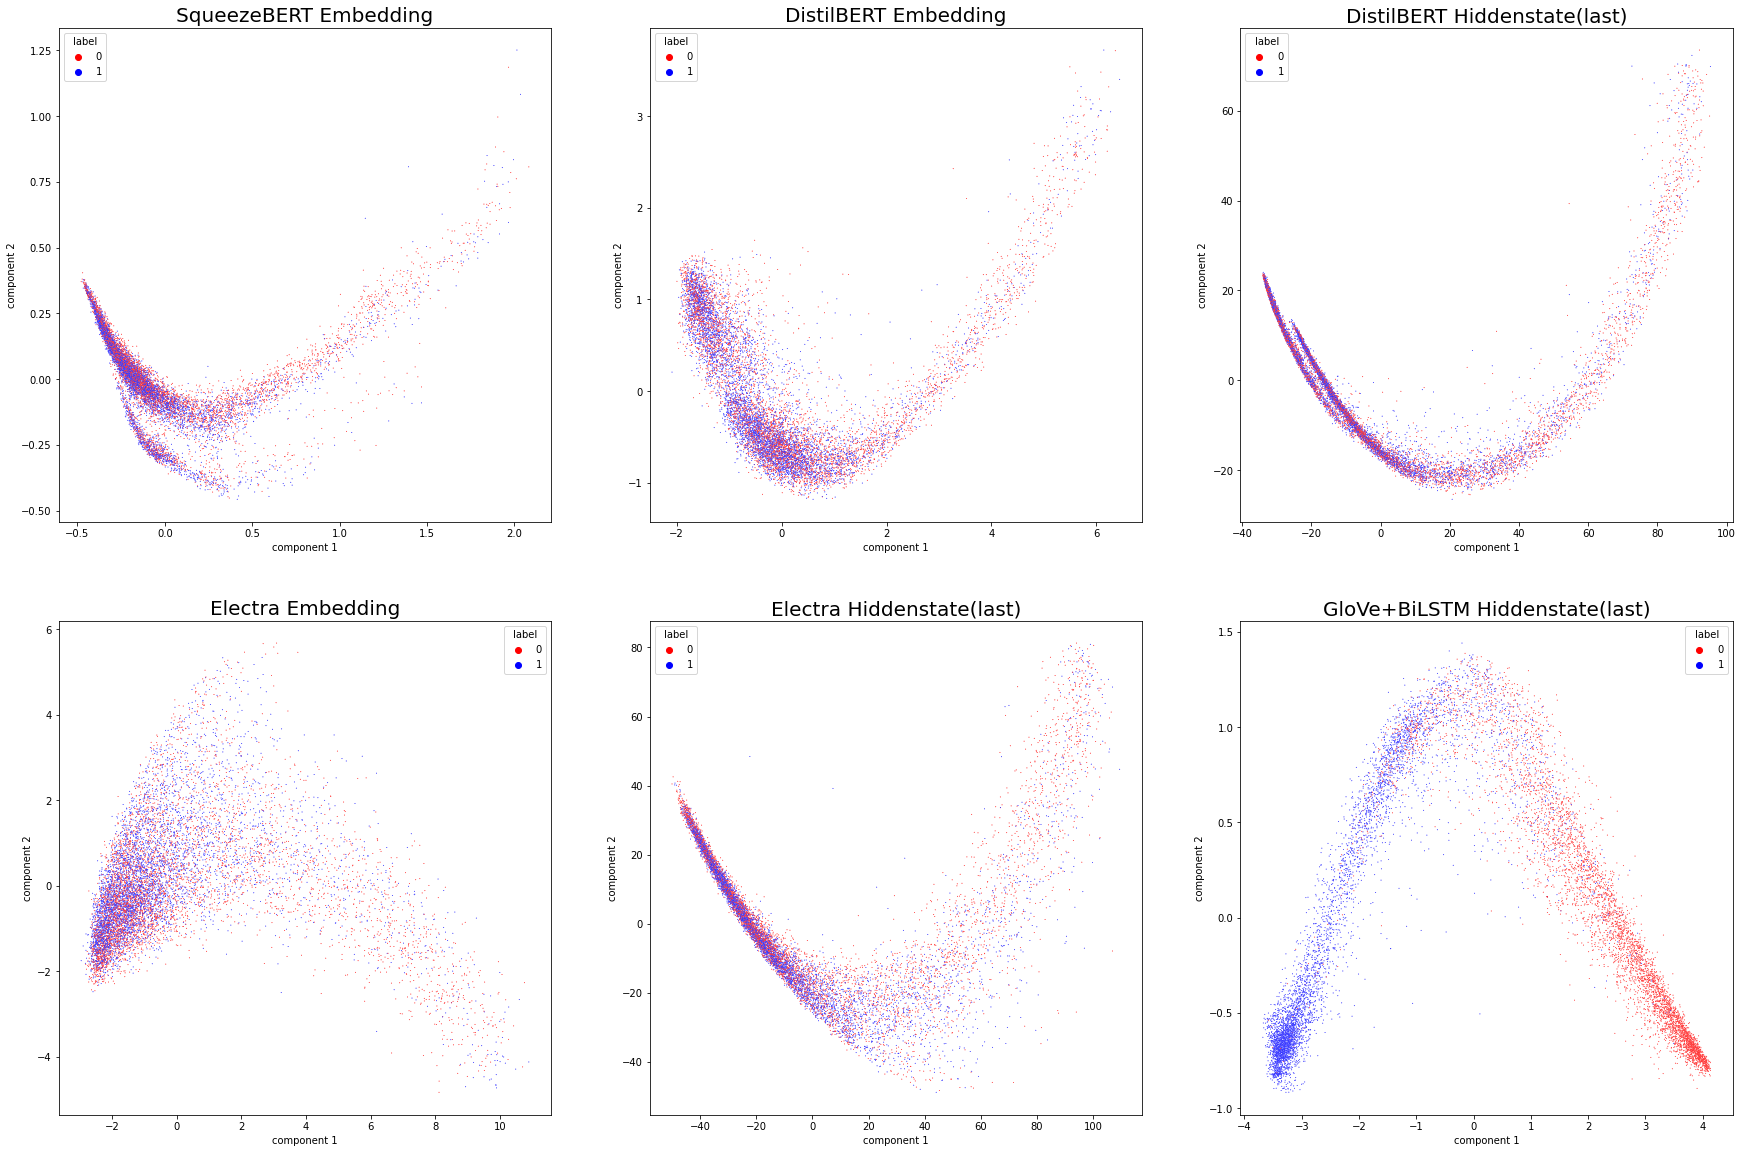

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(30,20))
pca_name = ['SqueezeBERT Embedding','DistilBERT Embedding','DistilBERT Hiddenstate(last)',
            'Electra Embedding','Electra Hiddenstate(last)','GloVe+BiLSTM Hiddenstate(last)']
pca_list = [df_squeeze_emb_pca,df_distil_emb_pca,np_distil_all_pca,df_electra_emb_pca,np_electra_all_pca,df_bilstm_pca]
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.title(pca_name[i],fontsize=20)
  sns.scatterplot(x=pca_list[i]['component 1'],
                  y=pca_list[i]['component 2'],
                  hue = 'label', data = pca_list[i], palette=['r','b'],s=1)

# Trained MODEL !

## BiLSTM

In [ ]:
ev=[]
pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(df_bilstm)
principalDf = pd.DataFrame(data = principalComponents, columns = ['component 1', 'component 2'])
df_bilstm_pca = pd.concat([principalDf, pd.DataFrame(y_bilstm_emb,columns=['label'])], axis=1)
ev.append([round(pca.explained_variance_ratio_[0]*100,2),round(pca.explained_variance_ratio_[1]*100,2)])
print(ev[-1])

[88.89, 5.43]


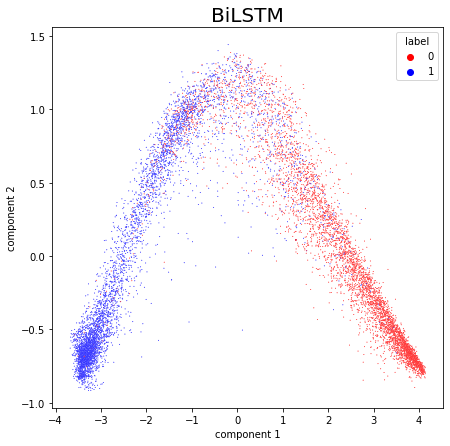

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(7,7))
plt.title("BiLSTM",fontsize=20)
sns.scatterplot(x=df_bilstm_pca['component 1'],
                y=df_bilstm_pca['component 2'],
                hue = 'label', data = df_bilstm_pca, palette=['r','b'],s=1)

## ELECTRA

In [ ]:
# ELECTRA
tokenizer_electra = ElectraTokenizer.from_pretrained('google/electra-small-discriminator')
model_electra = TFElectraForSequenceClassification.from_pretrained('google/electra-small-discriminator')
model_electra.load_weights("/content/drive/MyDrive/HateSpeech/Weight/ELECTRA")
model_electra = tf.keras.Sequential(model_electra.layers[:-1])


Some layers from the model checkpoint at google/electra-small-discriminator were not used when initializing TFElectraForSequenceClassification: ['discriminator_predictions']
- This IS expected if you are initializing TFElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
electra_hs = tokenizer_electra(X, truncation=True, padding=True)
electra_hs = tf.data.Dataset.from_tensor_slices((dict(electra_hs)))
electra_hs = model_electra.predict(electra_hs.batch(256)).last_hidden_state

Consider rewriting this model with the Functional API.
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [ ]:
electra_hs_reshape = electra_hs.reshape(10000,318*256)
electra_hs_reshape.shape

(10000, 81408)

In [ ]:
from sklearn.decomposition import PCA
ev=[]
pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(electra_hs_reshape)
principalDf = pd.DataFrame(data = principalComponents, columns = ['component 1', 'component 2'])
electra_pca = pd.concat([principalDf, pd.DataFrame(y_squeeze_emb,columns=['label'])], axis=1)
ev.append([round(pca.explained_variance_ratio_[0]*100,2),round(pca.explained_variance_ratio_[1]*100,2)])
print(ev[-1])

[68.51, 13.6]


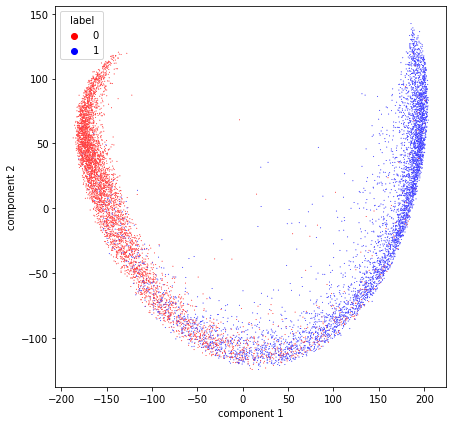

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(7,7))
plt.title("ELECTRA",fontsize=20)
sns.scatterplot(x=electra_pca['component 1'],
                y=electra_pca['component 2'],
                hue = 'label', data = electra_pca, palette=['r','b'],s=1)

## DistilBERT

In [ ]:
# DISTIL
tokenizer_distilbert = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model_distilbert = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
model_distilbert.load_weights("/content/drive/MyDrive/HateSpeech/Weight/DistilBERT")
model_distilbert = tf.keras.Sequential(model_distilbert.layers[:-3])

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'activation_13', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'pre_classifier', 'dropout_95']
You should probably TRAIN this model on a down-stream task to be able to use i

In [ ]:
model_distilbert.layers

In [ ]:
distil_hs = tokenizer_distilbert(X, truncation=True, padding=True)
distil_hs = tf.data.Dataset.from_tensor_slices((dict(distil_hs)))

In [ ]:
distil_hs = model_distilbert.predict(distil_hs.batch(1)).last_hidden_state

Consider rewriting this model with the Functional API.


In [ ]:
distil_hs_reshape = distil_hs.reshape(10000,distil_hs.shape[1]*distil_hs.shape[2])
distil_hs_reshape.shape

(10000, 244224)

In [ ]:
>>> from sklearn.preprocessing import StandardScaler
>>> data = [[0, 0], [0, 0], [1, 1], [1, 1]]
>>> scaler = StandardScaler()
>>> print(scaler.fit(data))
StandardScaler()
>>> print(scaler.mean_)
[0.5 0.5]
>>> print(scaler.transform(data))

In [ ]:
distil_hs_reshape

array([[-0.6484261 , -0.05057248, -0.844454  , ...,  0.11550917,
        -0.24764904, -0.3332053 ],
       [ 1.0846268 ,  1.2822281 ,  1.4832387 , ..., -0.3122861 ,
         1.0579528 , -0.19390535],
       [-0.3496923 , -0.44582805, -0.01684746, ..., -0.12935932,
        -0.28097564, -0.27275163],
       ...,
       [-0.59538865, -0.22787061, -0.7092987 , ..., -0.00580699,
        -0.0826287 , -0.46459794],
       [ 1.1999303 ,  1.4547254 ,  1.317911  , ..., -0.4281269 ,
         0.89107496, -0.00278452],
       [ 0.04105007,  0.30922505,  0.08788326, ..., -0.03997688,
         0.08500606,  0.0787866 ]], dtype=float32)

In [ ]:
from sklearn.decomposition import PCA
ev=[]
pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(distil_hs_reshape)
principalDf = pd.DataFrame(data = principalComponents, columns = ['component 1', 'component 2'])
distil_pca = pd.concat([principalDf, pd.DataFrame(y_squeeze_emb,columns=['label'])], axis=1)
ev.append([round(pca.explained_variance_ratio_[0]*100,2),round(pca.explained_variance_ratio_[1]*100,2)])
print(ev[-1])

[80.01, 9.64]


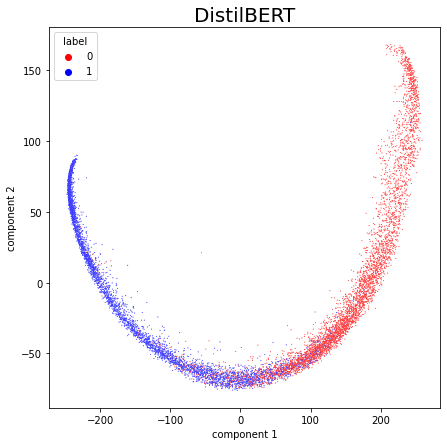

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(7,7))
plt.title("DistilBERT",fontsize=20)
sns.scatterplot(x=distil_pca['component 1'],
                y=distil_pca['component 2'],
                hue = 'label', data = electra_pca, palette=['r','b'],s=1)